# Product Fractionation
Key information for evaluating the separation performance of a chromatographic process are the amounts of the target components in the collected product fractions.
To define corresponding fractionation intervals, the chromatograms, i.e., the concentration profiles $c_{i,k}\left(t\right)$ at the outlet(s) of the process must be evaluated.
In a strict sense, a chromatogram is only given at the outlet of a single column. Note that here this term is used more generally for the concentration profiles at the outlets of a flow sheet, which only accounts for material leaving the process. 
The times for the start, $t_{start, j}$, and the end, $t_{end, j}$, of a product fraction $j$ have to be chosen such that constraints on product purity are met.
It is important to note, that in advanced chromatographic process configurations, outlet chromatograms can be much more complex than the example shown below and that multiple sections of the chromatogram may represent suitable fractions $j$ for collecting one target component $i$.
Moreover, flow sheets can have multiple outlets $k$ that have to be fractionated simultaneously.
Also, the volumetric flow rate $Q_k$ at the outlets may depend on time and needs to be considered in the integral.
These aspects are considered by defining the total product amount of a component $i$ as 

$$
m_{i} = \sum_{k=1}^{n_{chrom}} \sum_{j=1}^{n_{frac, k}^{i}}\int_{t_{start, j}}^{t_{end, j}} Q_k(t) \cdot c_{i,k}(t) dt,\\
$$

where $n_{frac, k}^{i}$ is the number of fractions considered for component $i$ in chromatogram $k$, and $n_{chrom}$ is the number of chromatograms that is evaluated. 

Further performance criteria typically used for evaluation and optimization of chromatographic performance are the specific productivity, $PR_i$, the recovery yield, $Y_i$, and the specific solvent consumption, $EC_i$, which all depend on the product amounts:

$$
PR_{i} = \frac{m_i}{V_{solid} \cdot \Delta t_{cycle}},\\
$$

$$
Y_{i} = \frac{m_i}{m_{feed, i}},\\
$$

$$
EC_{i} = \frac{V_{solvent}}{m_i},\\
$$

with $V_{solid}$ being the volume of stationary phase, $V_{solvent}$ that of the solvent introduced during a cycle with duration $\Delta t_{cycle}$, and $m_{feed}$ the injected amount of mixture to be separated. Multiple sources can be considered for the amounts of consumed feed and solvent,

$$
V_{solvent} = \sum_{s=1}^{n_{solvents}} \int_{0}^{t_{cycle}} Q_s(t) dt,\\
$$

$$
m_{feed,i} = \sum_{f=1}^{n_{feeds}} \int_{0}^{t_{cycle}} Q_f(t) \cdot c_{f,i}(t) dt.\\
$$

For the cumulative product purities $PU_i$ holds

$$
PU_{i} = \frac{m_{i}^{i}}{\sum_{l=1}^{n_{comp}} m_{l}^{i}},\\
$$

where $n_{comp}$ is the number of mixture components and $m_{l}^{i}$ is the mass of component $l$ in target fraction $i$.

In **CADET-Process**, the `fractionation` module provides methods to calculate these performance indicators.


## Fractionator
The `Fractionator` allows slicing the solution and pool fractions for the individual components.
It enables evaluating multiple chromatograms at once and multiple fractions per component per chromatogram.

The most basic strategy is to manually set all fractionation times manually.
To demonstrate the strategy, the simulation example from the previous tutorial.

In [3]:
import sys
sys.path.insert(0, '../../_templates')
from batch_elution import process

To enable the calculation of the process parameters, it is necessary to specify which of the inlets should be considered for the feed and eluent consumption.
Moreover, the outlet(s) which are used for evaluation need to be defined.

```
flow_sheet.add_feed_inlet('feed')
flow_sheet.add_eluent_inlet('eluent')
flow_sheet.add_product_outlet('outlet')
```

In [4]:
from CADETProcess.simulator import Cadet
process_simulator = Cadet()
simulation_results = process_simulator.simulate(process)

For reference, this is the chromatogram at the outlet that needs to be fractionated:

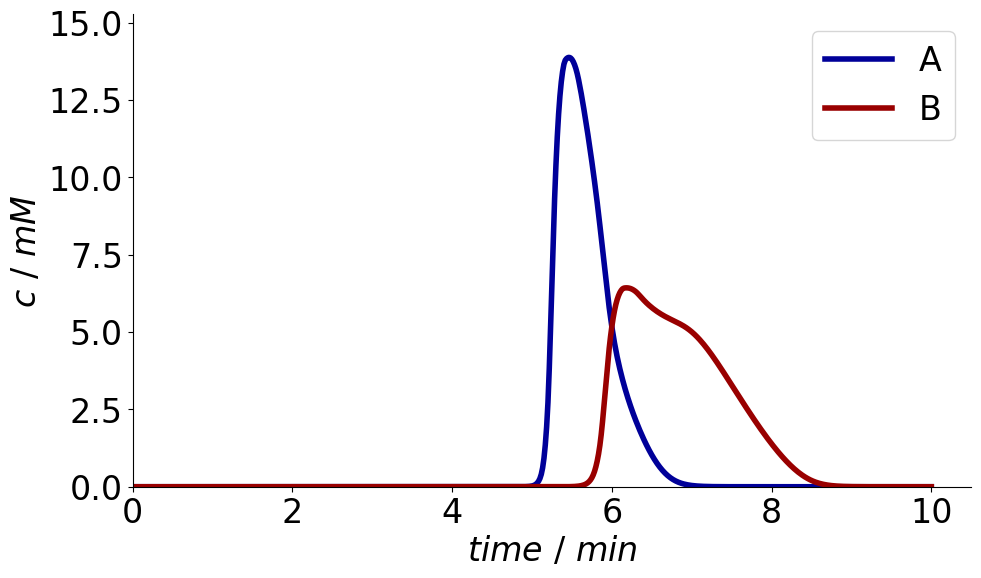

In [5]:
_ = simulation_results.solution.outlet.outlet.plot()

After import, the `Fractionator` is instantiated with the simulation results.

In [6]:
from CADETProcess.fractionation import Fractionator
fractionator = Fractionator(simulation_results)

To add a fractionation event, the following arguments need to be provided:
- `event_name`: Name of the event.
- `target`: Pool to which fraction is added. `-1` indicates waste. 
- `time`: Time of the event
- `chromatogram`: Name of the chromatogram. Optional if only one outlet is set as `chromatogram_sink`.

Here, component $A$ seems to have sufficient purity between $5 \colon 00~min$ and $5 \colon 45~min$ and component $B$ between $6 \colon 30~min$ and $9 \colon 00~min$.

In [7]:
fractionator.add_fractionation_event('start_A', 0, 5*60, 'outlet')
fractionator.add_fractionation_event('end_A', -1, 5.75*60)
fractionator.add_fractionation_event('start_B', 1, 6.5*60)
fractionator.add_fractionation_event('end_B', -1, 9*60)

The `performance` object of the `Fractionator` contains the parameters:

In [8]:
print(fractionator.performance)

Performance(mass=array([0.00039127, 0.00038088]), concentration=array([8.69481795, 2.53920449]), purity=array([0.99721983, 0.97224987]), recovery=array([0.65211135, 0.63480112]), productivity=array([0.00800824, 0.00779566]), eluent_consumption=array([0.72456816, 0.70533458]))


With these fractionation times, the both component fractions reach a purity of $99.7~\%$, and $97.2~\%$  respectively.
The recovery yields are $65.2~\%$ and $63.4~\%$.

The chromatogram can be plotted with the fraction times overlaid:

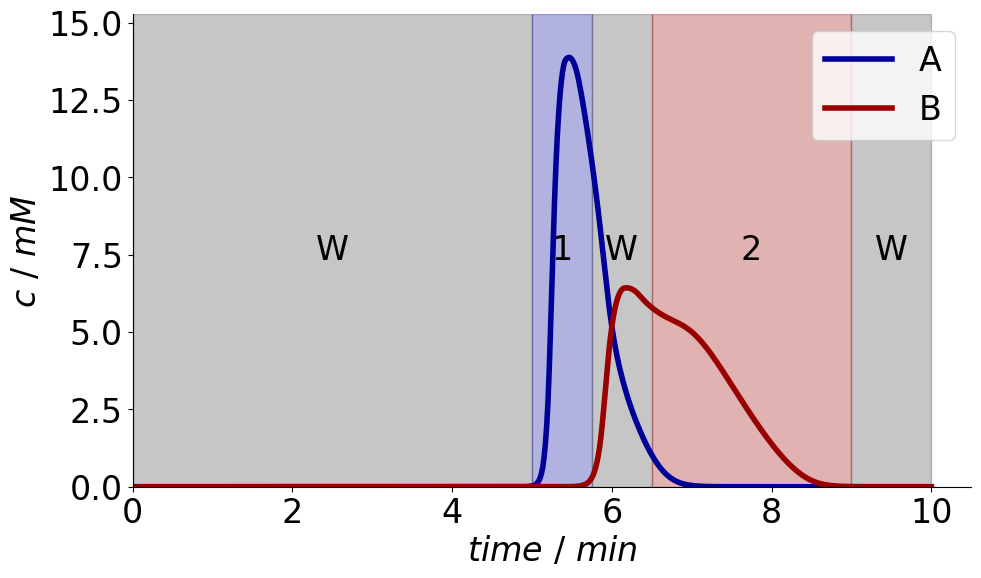

In [9]:
_ = fractionator.plot_fraction_signal()

## Optimization of Fractionation Times
The `Fractionation` module also provides a method to set up an `OptimizationProblem` which automatically determines optimal cut times.
For every component, different purity requirements can be specified, and any function may be applied as objective.

For the objective and constraint functions, fractions are pooled from all `Outlets` of the `FlowSheet` (see equations {eq}`mass` and {eq}`purity`).
As initial values for the optimization, areas of the chromatogram with sufficient local purity are identified, i.e., intervals where $PU_i(t)=c_i(t)/\sum_j c_j(t)\geq PU_{min,i}$ {cite}`Shan2004`.
These initial intervals are then expanded by the optimizer towards regions of lower purity while meeting the cumulative purity constraints.
In the current implementation, **COBYLA** {cite}`Powell1994` of the **SciPy** {cite}`SciPyContributors2020` library is used as `OptimizationSolver`
Yet, any other solver or heuristic algorithm may be used.

In [10]:
from CADETProcess.fractionation import FractionationOptimizer
fractionation_optimizer = FractionationOptimizer()

By default, the mass of the components is maximized under purity constraints.
However, other objective functions can be used.

To automatically optimize the fractionation times, pass the simulation results to the `optimize_fractionation` function.
Depending on the separation problem at hand, different purity requirements can be specified.
For example, here only the first component is relevant, and requires a purity $\ge 95~\%$:

In [11]:
fractionator = fractionation_optimizer.optimize_fractionation(simulation_results, purity_required=[0.95, 0])

The results are stored in a `Performance` object.

In [12]:
print(fractionator.performance)

Performance(mass=array([0.00049938, 0.        ]), concentration=array([6.21075517, 0.        ]), purity=array([0.94999966, 0.        ]), recovery=array([0.83230833, 0.        ]), productivity=array([0.01022114, 0.        ]), eluent_consumption=array([0.92478703, 0.        ]))


The chromatogram can also be plotted with the fraction times overlaid:

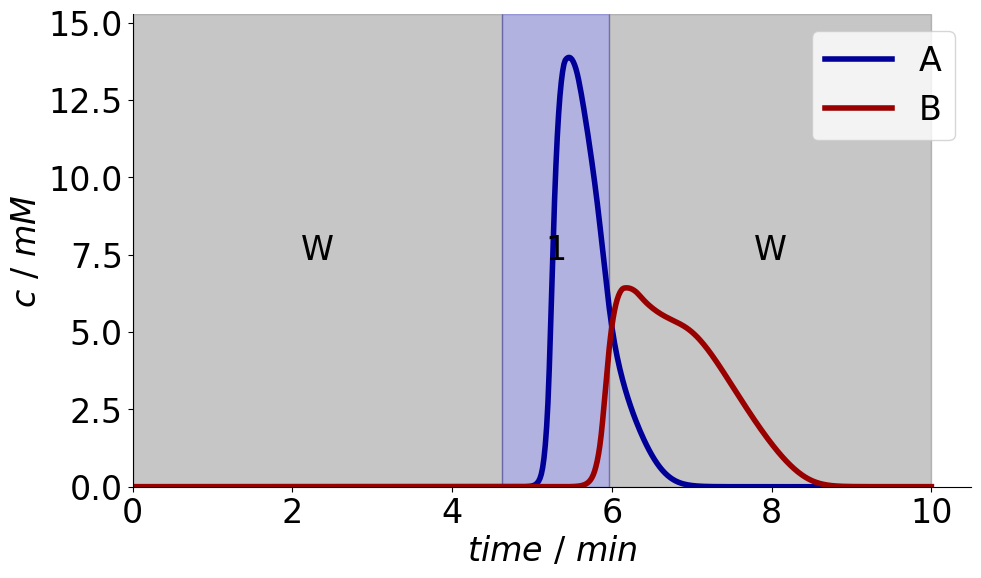

In [13]:
_ = fractionator.plot_fraction_signal()

For comparison, this is the results if only the second component is relevant:

Performance(mass=array([0.        , 0.00043198]), concentration=array([0.        , 2.09216192]), purity=array([0.  , 0.95]), recovery=array([0.        , 0.71996284]), productivity=array([0.        , 0.00884148]), eluent_consumption=array([0.        , 0.79995871]))


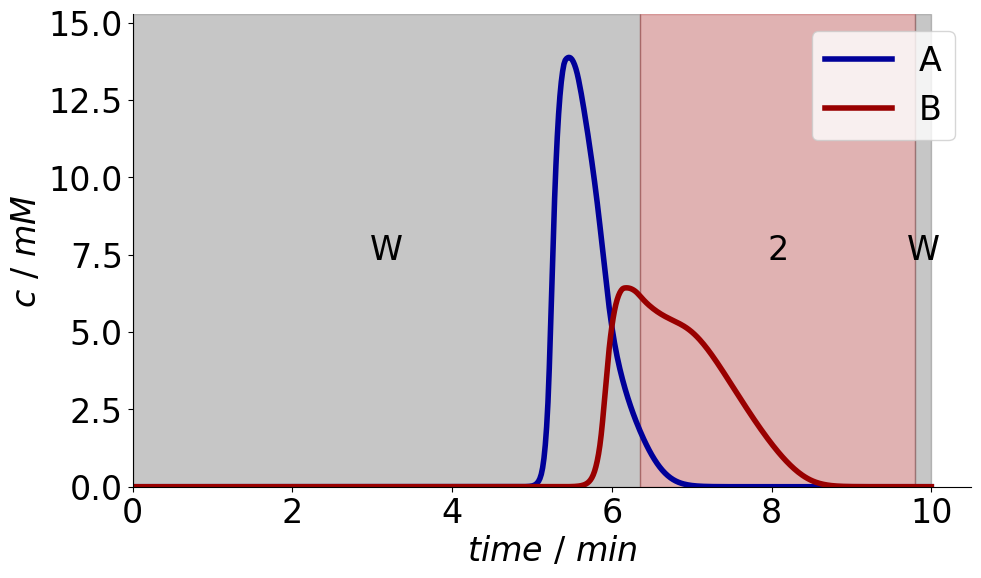

In [14]:
fractionator = fractionation_optimizer.optimize_fractionation(simulation_results, purity_required=[0, 0.95])

print(fractionator.performance)
_ = fractionator.plot_fraction_signal()

But of course, also both components can be valuable.
Here, the required purity is also reduced to demonstrate that overlapping fractions are automatically avoided by internally introducing linear constraints.

Performance(mass=array([0.00053986, 0.0005229 ]), concentration=array([6.1185671 , 2.42095989]), purity=array([0.87502602, 0.89685065]), recovery=array([0.89976865, 0.87149302]), productivity=array([0.01104959, 0.01070235]), eluent_consumption=array([0.99974294, 0.96832558]))


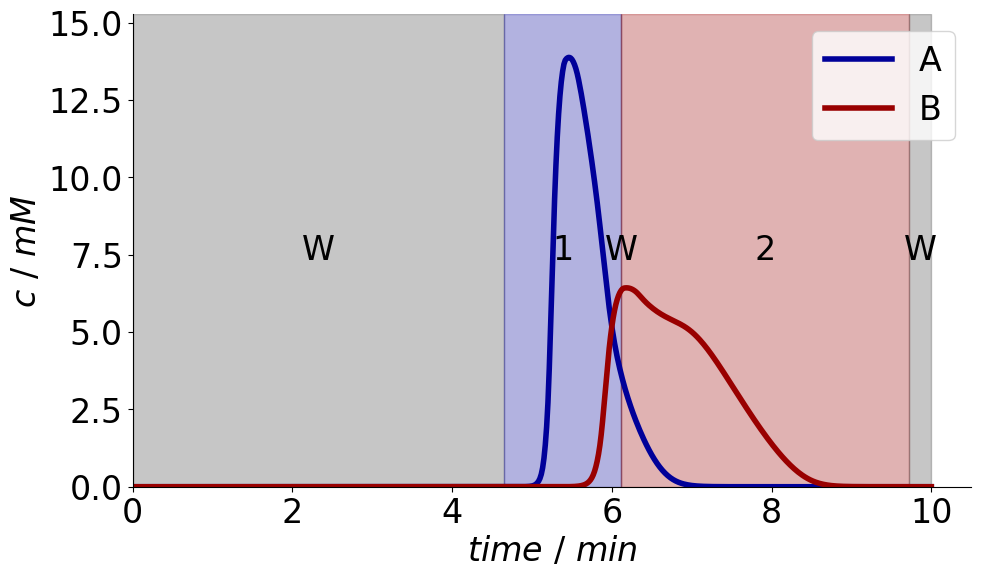

In [15]:
fractionator = fractionation_optimizer.optimize_fractionation(simulation_results, purity_required=[0.8, 0.8])

print(fractionator.performance)
_ = fractionator.plot_fraction_signal()

To set an alternative objective, a function needs to be passed that takes a `Performance` as an input.
In this example, not only the total mass is considered important but also the concentration of the fraction.
As previously mentioned, `COBYLA` only handles single objectives.
Hence, a `RankedPerformance` is used which transforms the `Performance` object by adding a weight $w_i$ to each component.

$$
p = \frac{\sum_i^{n_{comp}}w_i \cdot p_i}{\sum_i^{n_{comp}}(w_i)} 
$$

It is also important to remember that by convention, objectives are minimized.
Since in this example, the product of mass and concentration should be maximized, the value of the objective function is multiplied by $-1$.

Performance(mass=array([0.0004626 , 0.00041082]), concentration=array([11.37440959,  4.0122496 ]), purity=array([0.96596326, 0.94999998]), recovery=array([0.77100641, 0.68469608]), productivity=array([0.00946832, 0.00840839]), eluent_consumption=array([0.85667379, 0.76077343]))


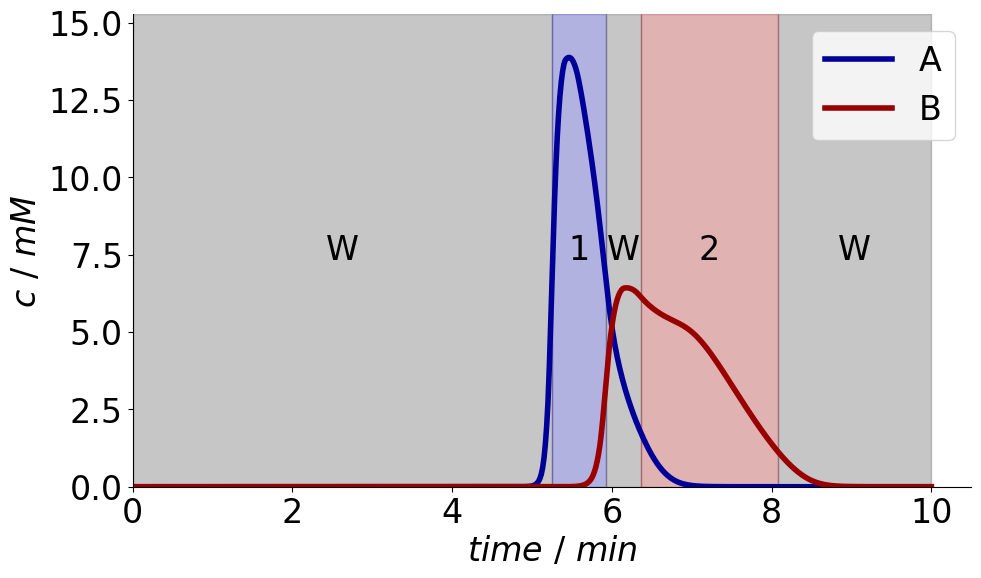

In [16]:
from CADETProcess.performance import RankedPerformance
ranking = [1, 1]
def alternative_objective(performance):
    performance = RankedPerformance(performance, ranking)
    return - performance.mass * performance.concentration

fractionator = fractionation_optimizer.optimize_fractionation(
    simulation_results, purity_required=[0.95, 0.95],
    obj_fun=alternative_objective,
)

print(fractionator.performance)
_ = fractionator.plot_fraction_signal()

The resulting fractionation times show that in this case, it is advantageous to discard some slices of the peak in order not to dilute the overall product fraction.